# U.S. Airbnb Open Data
### Airbnb listings and metrics of regions in the U.S.
https://www.kaggle.com/kritikseth/us-airbnb-open-data

Goal: We will be exploring Airbnb listings from the USA, the main goal of this Kernel will be exploring the data and predicting the price of a listing given a new sample. Our methodology in this Kernel will follow a standard analysis and prediction methodology where we will first assess the data for any missing values followed by outlier imputation.

The next stage will be the EDA where we will conduct two types of analysis: a distribution analysis on our numeric features and a location-based analysis hopefully seeing patterns in different locations in the USA which will support our model later on.

After we are done with the EDA we will construct our model, the model will consist of two parts, the first will be a sequential neural network with an embedding layer which will break down the name of the listing and create predictions based on those embeddings, the prediction from the sequential model will be fed into a random forest model together with the remaining numeric features from our dataset depending on what we find during the EDA, the idea is to create an ensembled model pipeline which will take full advantage of the listing name which is usually a key feature when looking at the price (many key features are described as words in the name and do not exist as individual features in our data.


In [3]:
# Libraries And Utilities

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import plotly.express as ex
import plotly.graph_objs as go
import string
import re
import nltk
from wordcloud import WordCloud,STOPWORDS
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from keras import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split
import tensorflow as tf
import os
import collections
def RMSE(Y,YHAT):
    return np.sqrt(mean_squared_error(Y,YHAT))

stopwords=list(STOPWORDS)

plt.rc('figure',figsize=(20,11))

def set_seed(seed=31415):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed()

In [4]:
# Data Importation And Missing Value Assessment
a_data = pd.read_csv('AB_US_2020.csv',usecols=['id','name','latitude','longitude','room_type','price','minimum_nights','number_of_reviews','last_review','reviews_per_month','calculated_host_listings_count',
                                                                                'availability_365','city'])
a_data.head(3)

,id,name,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,city
0,38585,Charming Victorian home - twin beds + breakfast,35.65146,-82.62792,Private room,60,1,138,16/02/20,1.14,1,0,Asheville
1,80905,French Chic Loft,35.59779,-82.55540,Entire home/apt,470,1,114,07/09/20,1.03,11,288,Asheville
2,108061,Walk to stores/parks/downtown. Fenced yard/Pet...,35.60670,-82.55563,Entire home/apt,75,30,89,30/11/19,0.81,2,298,Asheville


In [5]:
numeric_features = a_data.select_dtypes(include=['int64','float64']).columns
nominal_features = a_data.select_dtypes(include=['object'])
numeric_features=numeric_features.delete(0)

a_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226030 entries, 0 to 226029
Data columns (total 13 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   id                              226030 non-null  int64  
 1   name                            226002 non-null  object 
 2   latitude                        226030 non-null  float64
 3   longitude                       226030 non-null  float64
 4   room_type                       226030 non-null  object 
 5   price                           226030 non-null  int64  
 6   minimum_nights                  226030 non-null  int64  
 7   number_of_reviews               226030 non-null  int64  
 8   last_review                     177428 non-null  object 
 9   reviews_per_month               177428 non-null  float64
 10  calculated_host_listings_count  226030 non-null  int64  
 11  availability_365                226030 non-null  int64  
 12  city            

In [6]:
missing = a_data.isna().sum()

missing /= a_data.shape[0]
missing *=100
missing = missing.to_frame().rename(columns={0:'Precent Of Missing Values'})
missing

,Precent Of Missing Values
id,0.000000
name,0.012388
latitude,0.000000
longitude,0.000000
room_type,0.000000
price,0.000000
minimum_nights,0.000000
number_of_reviews,0.000000
last_review,21.502455
reviews_per_month,21.502455


Text(0.5, 1.0, 'Missing Values Proportion')

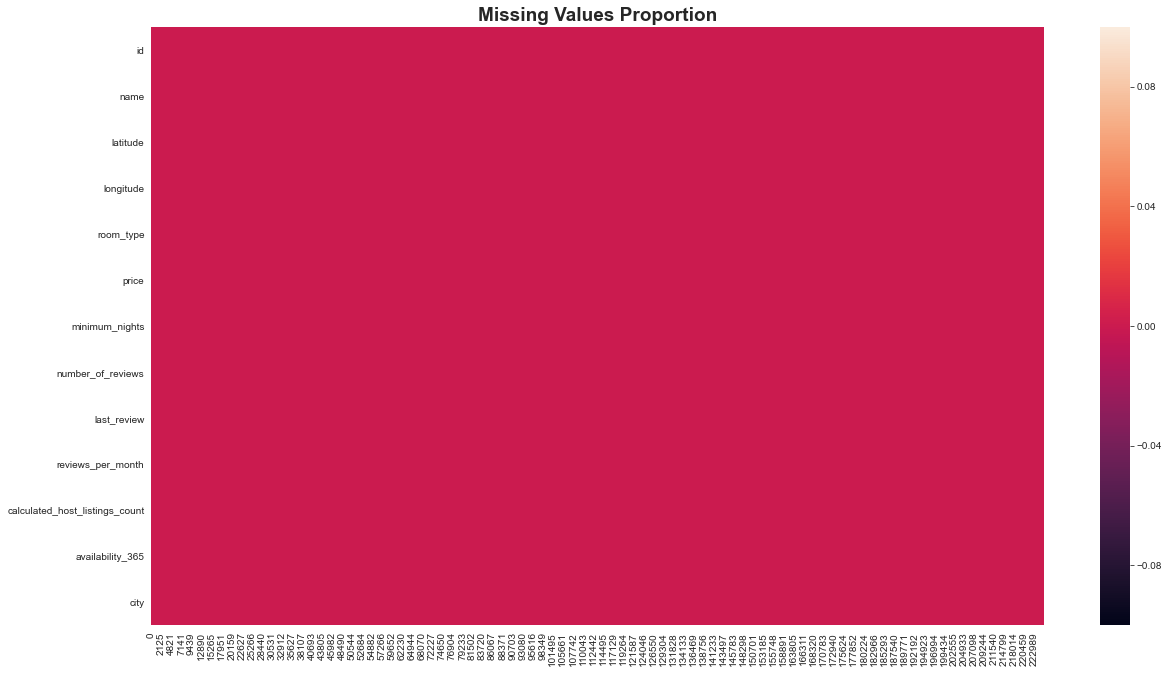

In [9]:
ax = sns.heatmap(a_data.isna().T)
ax.set_title('Missing Values Proportion',fontsize=19,fontweight='bold')

In [10]:
a_data = a_data.dropna()